The point of this notebook is to simulate low energy electrons in edep-sim and calculate the dE/dx vs residual range to compare to theory.

First edep-sim is run, then converted to h5py. Then the dE/dx and residual range

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
%%bash

rm -f dEdxVSRR.h5
edep-sim -e 10000 -p QGSP_BERT_LIV -o dEdxVSRR.root ../macros/Argon_39_betas.mac

% Set log level to LogLevel

**************************************************************
 Geant4 version Name: geant4-10-06-patch-03    (6-November-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

cryo is not found in /
drift is not found in /
% Set max segment length to 1 for drift
% Set max segment sagitta to 0.25 for drift
% Set max segment length to 1 for drift
% Set max segment sagitta to 0.5 for drift
% Set max segment length to 1 for drift
% Set max segment sagitta to 0.5 for drift
% Set max segment length to 1 for drift
% Set max segment sagitta to 0.5 for drift
% Set max segment length to 1 for drift
% Set max segment sagitta to 0.5 for drift
% Set max segment len

Info in <TGeoManager::TGeoManager>: Geometry EDepSimGeometry, Simulated Detector Geometry created
Info in <TGeoManager::SetVisLevel>: Automatic visible depth disabled
Info in <TGeoManager::SetTopVolume>: Top volume is volWorld_PV. Master volume is volWorld_PV
Info in <TGeoNavigator::BuildCache>: --- Maximum geometry depth set to 100
Info in <TGeoManager::CheckGeometry>: Fixing runtime shapes...
Info in <TGeoManager::CheckGeometry>: ...Nothing to fix
Info in <TGeoManager::CloseGeometry>: Counting nodes...
Info in <TGeoManager::Voxelize>: Voxelizing...
Info in <TGeoManager::CloseGeometry>: Building cache...
Info in <TGeoManager::CountLevels>: max level = 17, max placements = 5001
Info in <TGeoNodeCache::BuildIDArray>: --- node ID tracking enabled, size=644228 Bytes

Info in <TGeoManager::CloseGeometry>: 80528 nodes/ 64 volume UID's in Simulated Detector Geometry
Info in <TGeoManager::CloseGeometry>: ----------------modeler ready----------------
Info in <TGeoNodeMatrix::CheckOverlaps>: Ch

In [3]:
%run dumpTree.py dEdxVSRR.root dEdxVSRR.h5

Welcome to JupyROOT 6.22/09


100%|██████████| 10000/10000 [00:50<00:00, 198.27it/s]


In [6]:
from tqdm import tqdm

# open edep-sim file
f = h5py.File('dEdxVSRR.h5','r+')
numEvents = np.max(f['segments']['eventID']) + 1
events = f['segments'][f['segments']['trackID'] == 0]

print('Average number of segments per event = ', len(f['segments']) / numEvents)

# calculate residual range for each segment
resRange_all = np.array([]) # contains all segment residual ranges
dEdx_sim = np.array([])
KE_all = np.array([])
dEdx_event = []

for i in tqdm(range(numEvents)): # loops over each event
    event = events[events['eventID'] == i] # select event i
    
    if event.size != 0: # avoid empty events
        resRange,dEdx_event,KE_segments = np.zeros(event.size),np.zeros(event.size),np.zeros(event.size)
        
        for j in range(event.size):
            resRange[j] = np.sum(event['dx']) - np.sum(event['dx'][0:j])
            dEdx_event[j] = event['dE'][j]/event['dx'][j]
            KE_segments[j] = np.sum(event['dE']) - np.sum(event['dE'][0:j])

        resRange_all = np.concatenate((resRange_all,resRange))
        dEdx_sim = np.concatenate((dEdx_sim, dEdx_event))
        KE_all = np.concatenate((KE_all, KE_segments))
        
# get rid of infinities to avoid issues at binning stage
checkforINF = np.logical_not(np.isinf(dEdx_sim))
dEdx_sim = dEdx_sim[checkforINF]
resRange_all = resRange_all[checkforINF]
KE_all = KE_all[checkforINF]

Average number of segments per event =  60.2082


  8%|▊         | 754/10000 [00:05<01:02, 147.83it/s]/tmp/ipykernel_53525/3774631502.py:23: RuntimeWarning: divide by zero encountered in float_scalars
  dEdx_event[j] = event['dE'][j]/event['dx'][j]
100%|██████████| 10000/10000 [01:19<00:00, 125.31it/s]


<IPython.core.display.Javascript object>


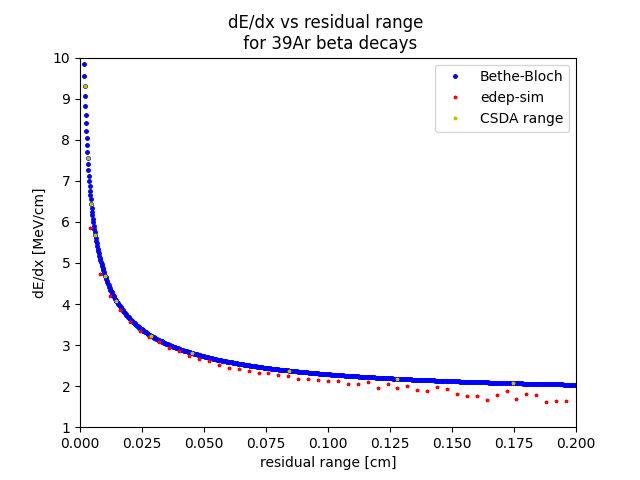

In [20]:
# calculate dE/dx and residual range from theory
import theory
import importlib
importlib.reload(theory)
E_i = 0.565
N = 500
residualRange_theory, dEdx_theory, energies = theory.dEdxANDRR(E_i, N)

# perform binning for simulation for comparison to theory
from scipy import stats
sim_binned = stats.binned_statistic(resRange_all,dEdx_sim, statistic='mean', bins = 50, range=(0.0,0.2))
sim_mean = sim_binned.statistic
sim_binedges = sim_binned.bin_edges

# calculate tracklengths from theory, for residual range
from scipy import integrate
from theory import *

E_end = 0.001
tracklengths = np.zeros_like(energies)
for i,E_i in enumerate(energies):
    tracklength = abs(integrate.quad(FullRange, E_i, E_end)[0]) # cm
    tracklengths[i] = tracklength
    
CSDA_range = np.array([3.921E-04,7.849E-04,1.289E-03,2.599E-03,4.276E-03,6.283E-03,8.594E-03,1.403E-02,2.042E-02,3.985E-02,6.309E-02,1.175E-01,1.787E-01,2.440E-01,3.119E-01,4.518E-01,5.939E-01])/1.397
CSDA_dEdx = np.array([1.497E+01,1.110E+01,8.974E+00	,6.657E+00,5.404E+00,4.613E+00,4.067E+00,3.358E+00,2.917E+00,2.312E+00,2.004E+00,1.701E+00,1.558E+00,1.480E+00,1.435E+00,1.391E+00,1.376E+00])*1.397

%matplotlib notebook
plt.plot(tracklengths,dEdx_theory,'bo', markersize = 2.5,label='Bethe-Bloch')
plt.plot(sim_binedges[0:-1],sim_mean,'r*',markersize= 2.5,label='edep-sim')
plt.plot(CSDA_range, CSDA_dEdx, 'y*',markersize=2.5,label='CSDA range')

plt.ylabel('dE/dx [MeV/cm]')
plt.xlabel('residual range [cm]')
plt.title('dE/dx vs residual range \n for 39Ar beta decays')
plt.xlim(0,0.20)
plt.ylim(1,10)
plt.legend()
#plt.savefig('dEdxVSRR_Argon39_edep0001.pdf')
plt.show()

<IPython.core.display.Javascript object>


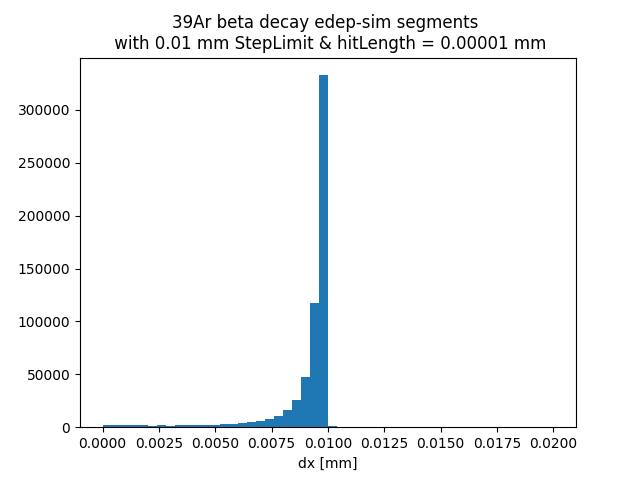

Text(0.5, 0, 'dx [mm]')

In [27]:
%matplotlib notebook
plt.hist(f['segments']['dx']*10, bins=50, range=(0,0.02))
plt.title('39Ar beta decay edep-sim segments \n with 0.01 mm StepLimit & hitLength = 0.00001 mm')
plt.xlabel('dx [mm]')